In [5]:
import rasterio

filepath = "downloads/S2B_MSIL2A_20210701T095029_N0301_R079_T34UDF_20210701T124116.SAFE/GRANULE/L2A_T34UDF_A022556_20210701T095030/IMG_DATA/R10m/T34UDF_20210701T095029"

dataset = rasterio.open(filepath + '_B03_10m.jp2')
dataset2 = rasterio.open(filepath + '_B08_10m.jp2')

In [112]:
dataset.crs
dataset.crs.to_wkt()

'PROJCS["WGS 84 / UTM zone 34N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",21],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32634"]]'

array([[384, 376, 368, ..., 452, 444, 441],
       [391, 377, 350, ..., 450, 446, 444],
       [330, 318, 326, ..., 441, 447, 444],
       ...,
       [794, 786, 794, ..., 756, 702, 711],
       [799, 819, 809, ..., 780, 736, 782],
       [788, 794, 808, ..., 707, 678, 747]], dtype=uint16)

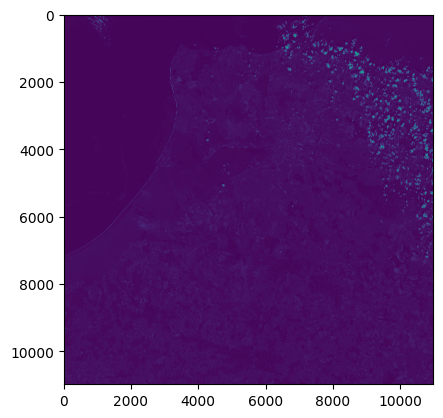

In [6]:
import matplotlib.pyplot as plt

image_band_1 = dataset.read(1)
plt.imshow(image_band_1)
image_band_1

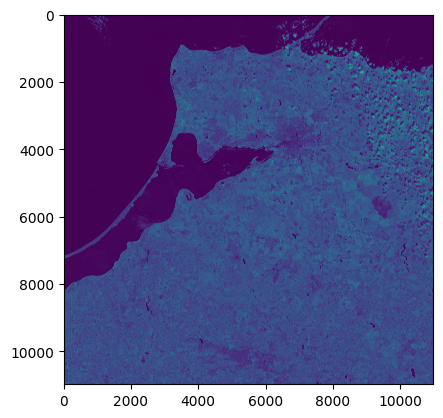

In [7]:
image_band_2 = dataset2.read(1)
plt.imshow(image_band_2)

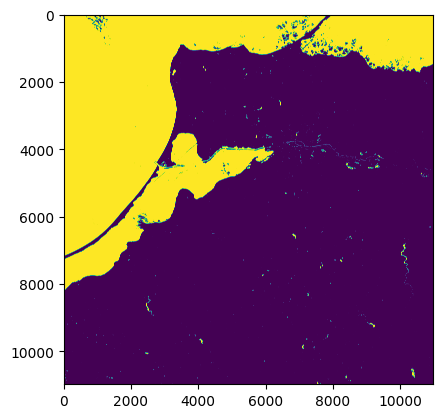

In [13]:
import numpy as np

# map 0 - ~16000 to 0.0 - 1.0
image_band_1_norm = image_band_1 / np.max(np.abs(image_band_1))
image_band_2_norm = image_band_2 / np.max(np.abs(image_band_2))

# 1 or 0 (water or not)
image_ndwi = (image_band_1_norm - image_band_2_norm) // (image_band_1_norm + image_band_2_norm + np.ones((image_band_1_norm.shape[0], image_band_1_norm.shape[1]))) + np.ones((image_band_1_norm.shape[0], image_band_1_norm.shape[1]))

# water mask true or false
water_mask = image_ndwi > 0.1

# show
plt.imshow(image_ndwi.astype('uint16'))

Opening file downloads/S2B_MSIL2A_20210701T095029_N0301_R079_T34UDF_20210701T124116.SAFE/GRANULE/L2A_T34UDF_A022556_20210701T095030/IMG_DATA/R10m/T34UDF_20210701T095029_B02_10m.jp2
Opening file downloads/S2B_MSIL2A_20210701T095029_N0301_R079_T34UDF_20210701T124116.SAFE/GRANULE/L2A_T34UDF_A022556_20210701T095030/IMG_DATA/R10m/T34UDF_20210701T095029_B03_10m.jp2
Opening file downloads/S2B_MSIL2A_20210701T095029_N0301_R079_T34UDF_20210701T124116.SAFE/GRANULE/L2A_T34UDF_A022556_20210701T095030/IMG_DATA/R10m/T34UDF_20210701T095029_B04_10m.jp2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


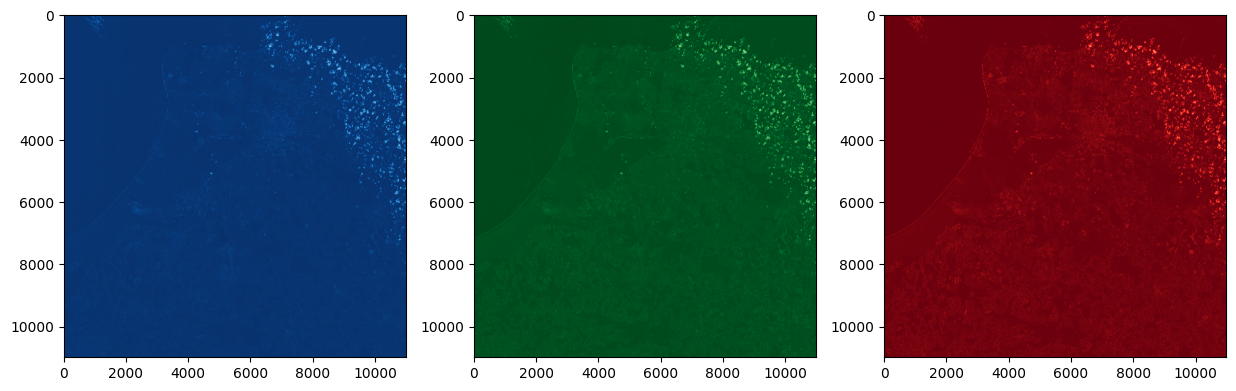

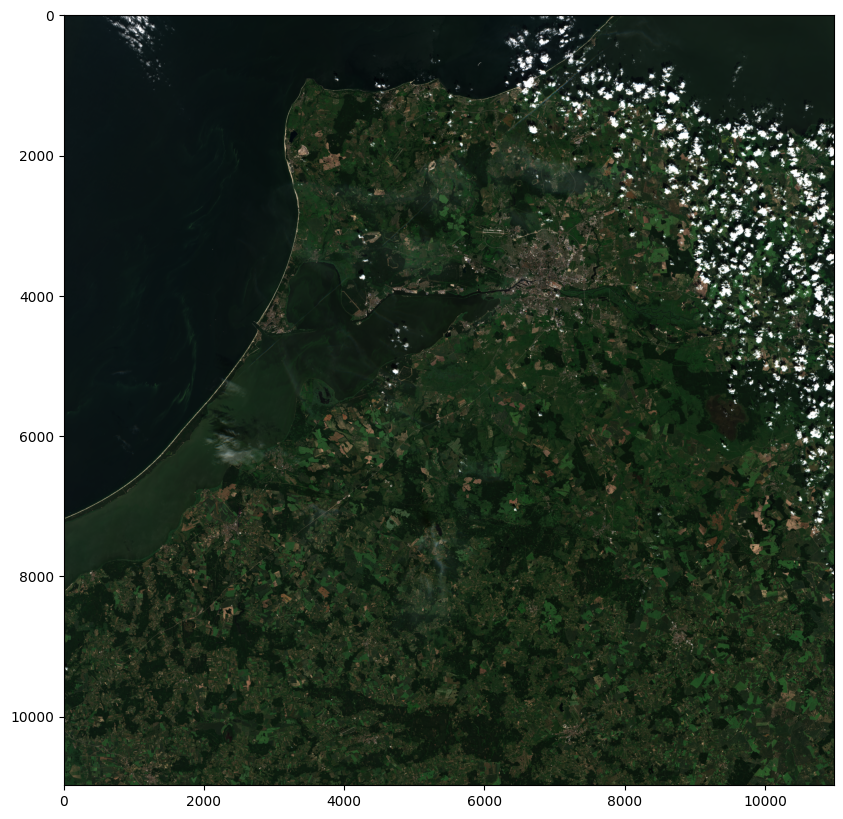

In [93]:
def load_sentinel_image(img_folder, filename, bands, scale):
    image = {}
    for band in bands:
        file = img_folder + 'R' + scale + 'm/' + filename + '_' + band + '_' + scale + 'm.jp2'
        print(f'Opening file {file}')
        ds = rasterio.open(file)
        image.update({band: ds.read(1)})

    return image


def display_rgb(img, b_r, b_g, b_b, alpha = 1., figsize = (10, 10)):
    rgb = np.stack([img[b_r], img[b_g], img[b_b]], axis = -1)
    rgb = rgb / rgb.max() * alpha
    plt.figure(figsize = figsize)
    plt.imshow(rgb)


img = load_sentinel_image(filepath[:filepath.index("IMG_DATA") + 9], filepath[filepath.index("IMG_DATA") + 14:], ['B02', 'B03', 'B04'], '10')

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].imshow(img['B02'], cmap = 'Blues_r')
ax[1].imshow(img['B03'], cmap = 'Greens_r')
ax[2].imshow(img['B04'], cmap = 'Reds_r')

display_rgb(img, 'B04', 'B03', 'B02', alpha = 5.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


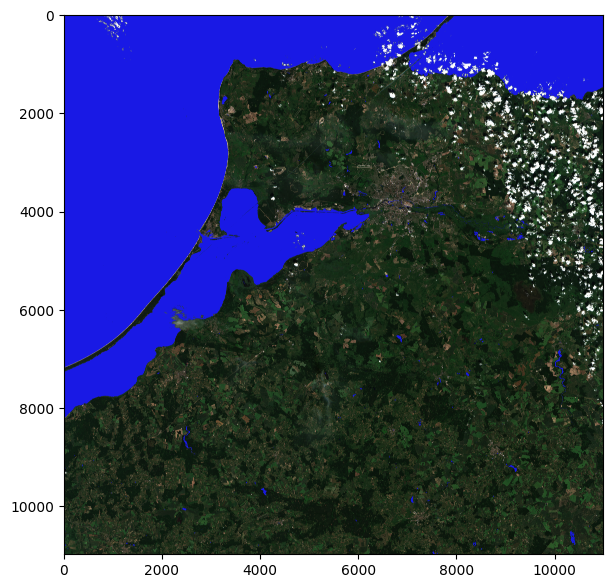

In [15]:
def new_water_mask_downscale(old_mask, old_shape, new_shape):
    new_mask = np.full((new_shape, new_shape), False)
    for i in range(new_shape):
        for j in range(new_shape):
            new_mask[i][j] = old_mask[(old_shape // new_shape) * i][(old_shape // new_shape) * j]
    
    return new_mask

rgb = np.stack([img['B04'], img['B03'], img['B02']], axis = -1)
rgb = rgb / rgb.max() * 5.

if (water_mask.shape[0] != rgb.shape[0]):
    water_mask = new_water_mask_downscale(water_mask, water_mask.shape[0], rgb.shape[0])

rgb[water_mask] = [0.1, 0.1, 0.9]

plt.figure(figsize = (7, 7))
plt.imshow(rgb)

In [16]:
from sklearn.cluster import DBSCAN
water_indexes = np.transpose(water_mask.nonzero())
clusters = DBSCAN(eps = 5.0, min_samples = 10).fit(water_indexes)
clusters.labels_

array([  0,   0,   0, ..., 701, 701, 701])

In [17]:
# Filter no-clusters and small clusters
cluster_threshold = 8000
unique, counts = np.unique(clusters.labels_, return_counts = True)
cluster_indexes = dict(zip(unique, counts))
cluster_indexes_above_thre = {k: v for k, v in cluster_indexes.items() if v > cluster_threshold and k != -1}
cluster_indexes_above_thre

{0: 29253691,
 1: 4935709,
 72: 11330,
 291: 8910,
 451: 21184,
 527: 13030,
 659: 15565}

In [18]:
cluster_mask = [idx in cluster_indexes_above_thre for idx in clusters.labels_]
water_indexes_image_coords = water_indexes[cluster_mask]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


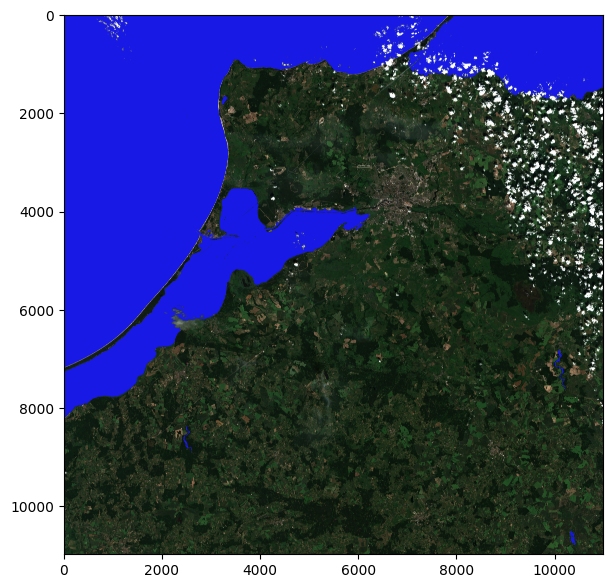

In [19]:
rgb = np.stack([img['B04'], img['B03'], img['B02']], axis=-1)
rgb = rgb/rgb.max() * 5

X = water_indexes_image_coords[:, 0]
Y = water_indexes_image_coords[:, 1]
mask_matrix = np.zeros((10980, 10980), dtype='bool')
mask_matrix[X, Y] = True
mask_matrix
rgb[mask_matrix] = [0.1, 0.1, 0.9]

plt.figure(figsize = (7,7))
plt.imshow(rgb)

In [12]:
print(mask_matrix)
print(water_indexes_image_coords)

[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[    0     0]
 [    0     1]
 [    0     2]
 ...
 [10908  4595]
 [10908  4596]
 [10909  4593]]


In [143]:
data_transform = dataset.transform

move_to_real_coords = lambda water_idx: data_transform * water_idx

# print(water_indexes_real_coords)
# print(clusters.labels_)

zipped_water_clusters = zip(water_indexes, clusters.labels_)
water_cluster_points = {}
for point, cluster_idx in zipped_water_clusters:
    if cluster_idx not in water_cluster_points and cluster_idx in cluster_indexes_above_thre:
        water_cluster_points[cluster_idx] = point
    
print(len(water_cluster_points))
print(list(water_cluster_points.items())[:10])

water_indexes_real_coords = np.array([move_to_real_coords(np.array([xi[1], xi[0]])) for xi in water_cluster_points.values()])
water_indexes_real_coords

7
[(0, array([0, 0])), (1, array([   0, 7980])), (72, array([1638, 3272])), (291, array([4234, 6090])), (451, array([ 6814, 10077])), (527, array([8371, 2503])), (659, array([10505, 10342]))]


array([[ 399960., 6100020.],
       [ 479760., 6100020.],
       [ 432680., 6083640.],
       [ 460860., 6057680.],
       [ 500730., 6031880.],
       [ 424990., 6016310.],
       [ 503380., 5994970.]])

In [ ]:
# import utm

# print(water_cluster_points)

# for idx, cor in water_cluster_points.items():
#     water_cluster_points[idx] = utm.to_latlon(cor[0], cor[1], 34, 'U')  # 33 - left part of Poland, 34 - right part of Poland

# print(list(water_cluster_points.items())[:10])

In [144]:
from pyproj import transform
from rasterio.crs import CRS
from rasterio.warp import transform

zipped_final_result = zip(water_cluster_points, water_indexes_real_coords)
new_crs = CRS.from_epsg(4326)

export_to_db_dic = {}

for result in list(zipped_final_result):
    new_coo = transform(dataset2.crs, new_crs, xs=[result[1][0]], ys=[result[1][1]])
    export_to_db_dic[result[0]] = [new_coo[1][0], new_coo[0][0]]

export_to_db_dic


{0: [55.03692054159784, 19.4346016390245],
 1: [55.04657393156168, 20.68322683989857],
 72: [54.89525391897372, 19.95032041177108],
 291: [54.66497234272443, 20.393178623331796],
 451: [54.434624431229544, 21.01125416944789],
 527: [54.28918662750187, 19.84764864969051],
 659: [54.10288472820522, 21.051691598285828]}

In [145]:
from ibmcloudant.cloudant_v1 import CloudantV1, Document
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import time

authenticator = IAMAuthenticator("")
service = CloudantV1(authenticator=authenticator)
service.set_service_url("")

for cluster_point in list(export_to_db_dic.items()):
    print(cluster_point)
    doc_sample = Document(
        type="Feature",
        properties={"idx": int(cluster_point[0])},
        geometry={
            "type": "Point",
            "coordinates": [cluster_point[1][1], cluster_point[1][0]],
        }
    )
    service.put_document(db='senti-water-points', doc_id=str(cluster_point[0]), document=doc_sample)
    time.sleep(0.25)

(0, [55.03692054159784, 19.4346016390245])
(1, [55.04657393156168, 20.68322683989857])
(72, [54.89525391897372, 19.95032041177108])
(291, [54.66497234272443, 20.393178623331796])
(451, [54.434624431229544, 21.01125416944789])
(527, [54.28918662750187, 19.84764864969051])
(659, [54.10288472820522, 21.051691598285828])


In [44]:
# import fiona
# from shapely.geometry import Point, mapping

# schema = {'geometry': 'Point', 'properties': {'idx': 'int'}}

# with fiona.open('shp/punkty.shp', 'w', crs = dataset.crs.to_wkt(), driver = 'ESRI Shapefile', schema = schema) as output:
#     for idx, coordinates in water_cluster_points.items():
#         point = Point(float(coordinates[0]), float(coordinates[1]))
#         prop = {'idx': int(idx)}
#         output.write({'geometry': mapping(point), 'properties': prop})

# # sprawdzenie
# c = fiona.open('shp/punkty.shp', 'r')
# print(len(c))
# print(next(iter(c)))
# print(c.crs)
# print(c[100])

210
{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('idx', 0)]), 'geometry': {'type': 'Point', 'coordinates': (55.04698603069178, 20.999686980376282)}}
{'init': 'epsg:32634'}
{'type': 'Feature', 'id': '100', 'properties': OrderedDict([('idx', 99)]), 'geometry': {'type': 'Point', 'coordinates': (54.60826801564791, 22.546270524951776)}}
